In [1]:
%matplotlib inline
from dendrosplit import *
np.set_printoptions(precision=2,suppress=True)

# Running the pipeline

In [2]:
import pickle

# Load data
dataset = 'Resolve4'
X,genes = pickle.load(file('/Users/jessezhang/Desktop/datasets/'+dataset+'.pickle'))
x1,x2 = pickle.load(file('/Users/jessezhang/Desktop/datasets/'+dataset+'tsne.pickle'))

# Perform the clustering
preprocessor = log_correlation
y,history = dendrosplit(X,
                        preprocessing=preprocessor,
                        min_clust_size=10,
                        score_threshold=10,
                        method='complete',
                        verbose=False,
                        split_evaluator=select_genes_using_Welchs)

# Merge cluster labels
ymerged = merge_cleanup(X,y,10,verbose=False)

/Users/jessezhang/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/Users/jessezhang/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in less
  cond1 = (scale > 0) & (x > self.a) & (x < self.b)
/Users/jessezhang/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1749: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# Visualizing results

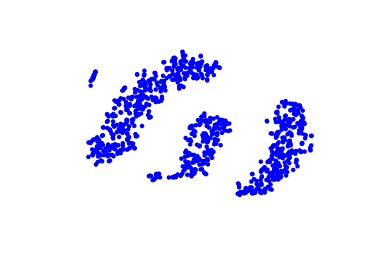

In [3]:
# Original data
plt.scatter(x1,x2,edgecolors='none')
_ = plt.axis('off')

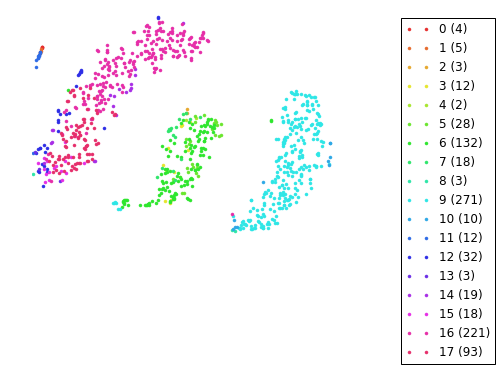

In [4]:
# Clustering results using pre-merged labels
plot_labels_legend(x1,x2,str_labels_to_inds(y))

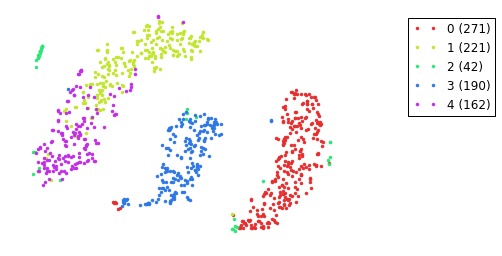

In [5]:
# Clustering results using post-merged labels
plot_labels_legend(x1,x2,str_labels_to_inds(ymerged))

We can get an idea of how the algorithm handled the dataset using the "print_history" function. Line i describes the ith valid split. A split is deemed valid if both clusters generated are above the min_clust_size and the lowest p-value generated from the split is below the threshold.

In [6]:
print_history(genes,history)

Pre-split: 882    Left: 484    Right: 398    Score: 182.248  Top Gene: HBG1        Top Gene Score: 182.248
Pre-split: 479    Left: 195    Right: 284    Score: 113.520  Top Gene: CD3D        Top Gene Score: 113.520
Pre-split: 195    Left: 177    Right: 18     Score: 15.354  Top Gene: RRP7A       Top Gene Score: 15.354
Pre-split: 174    Left: 12     Right: 162    Score: 18.881  Top Gene: ANXA11      Top Gene Score: 18.881
Pre-split: 160    Left: 28     Right: 132    Score: 12.315  Top Gene: TTF1        Top Gene Score: 12.315
Pre-split: 281    Left: 271    Right: 10     Score: 38.044  Top Gene: RNASEH2B    Top Gene Score: 38.044
Pre-split: 386    Left: 32     Right: 354    Score: 33.236  Top Gene: VMP1        Top Gene Score: 33.236
Pre-split: 351    Left: 19     Right: 332    Score: 32.863  Top Gene: EIF2B1      Top Gene Score: 32.863
Pre-split: 314    Left: 221    Right: 93     Score: 48.699  Top Gene: RPL27A      Top Gene Score: 48.699


We can also visualize which points were involved in each split. Each row has 2 figures. Row i describes the ith split saved. In each row, the left figure indicates how the split was carried out. Blue points were not involved in the split at all. Red and green points used to be in the same cluster and are now separated. The title of the left figure represents the 4 genes that achieved the largest t statistic (after taking an absolute value). The number associated with each gene is the -log10 of the corresponding p value. The right figure shows the log expression of the gene that achieved the largest t statistic.

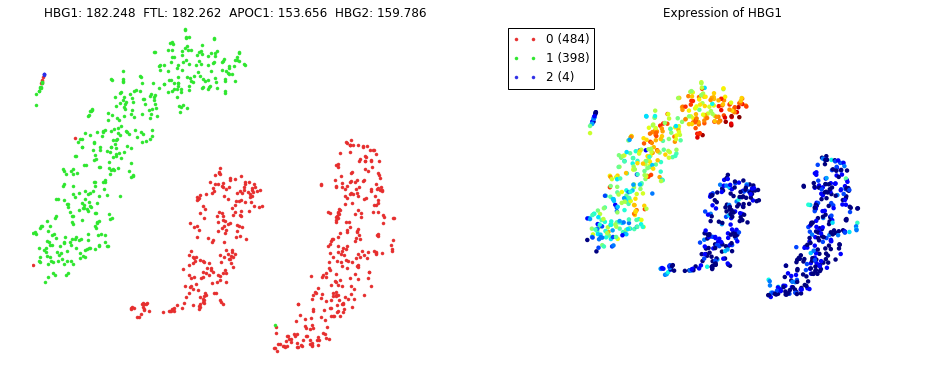

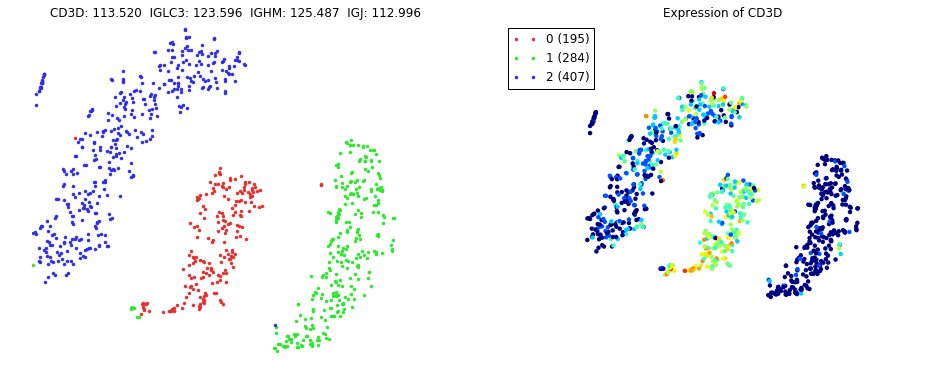

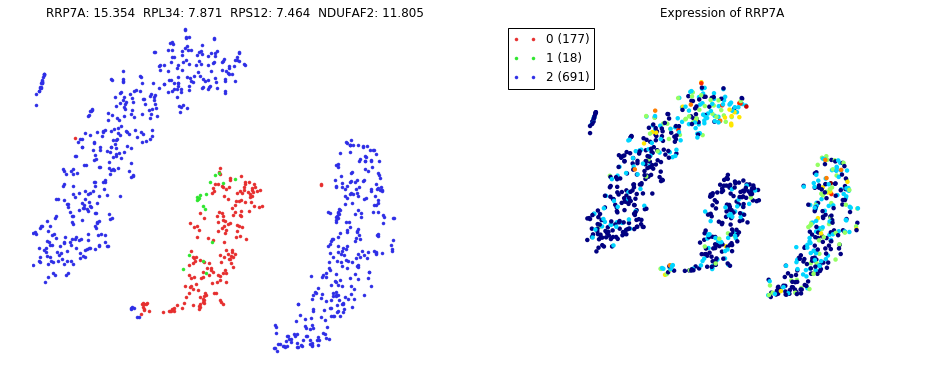

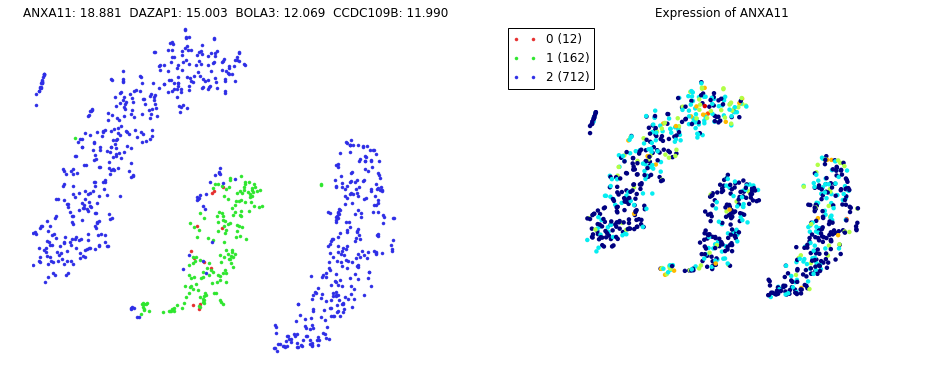

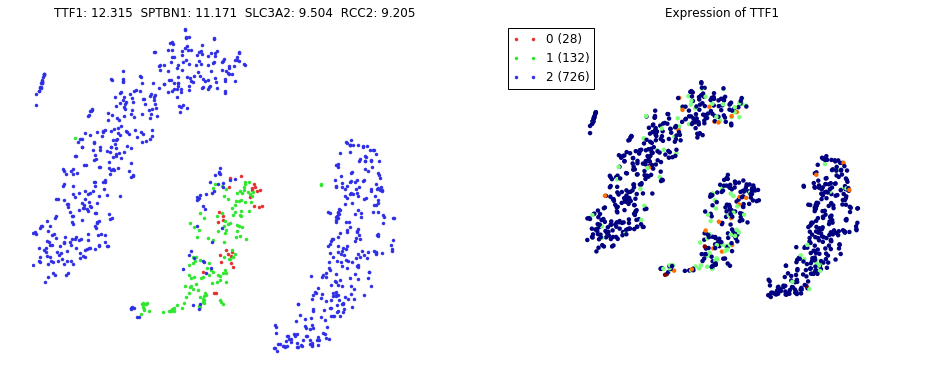

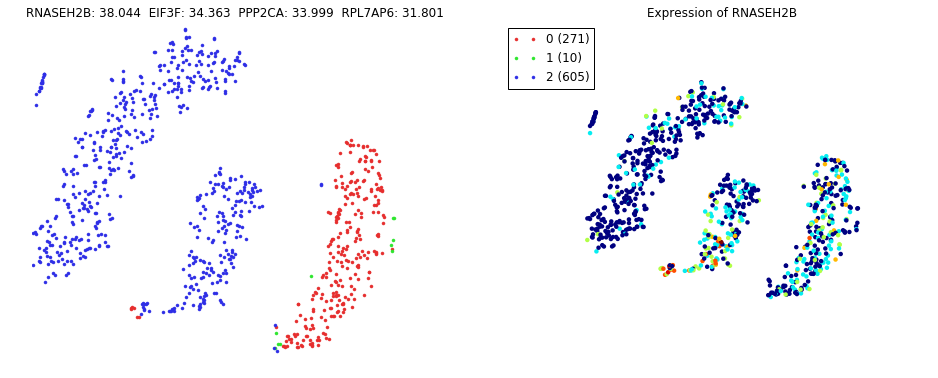

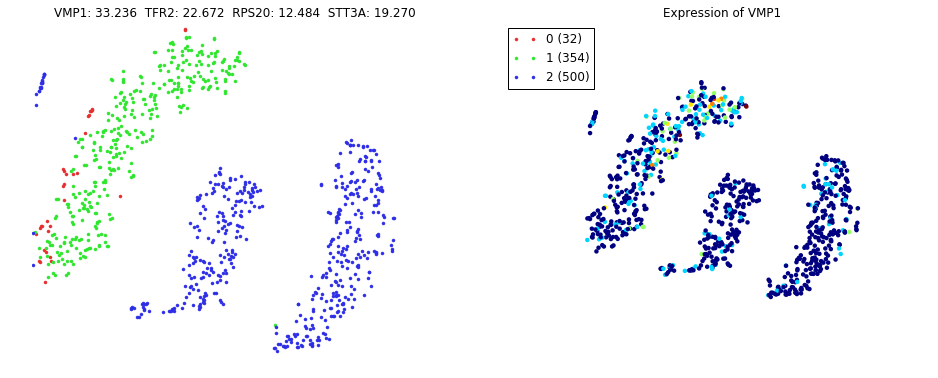

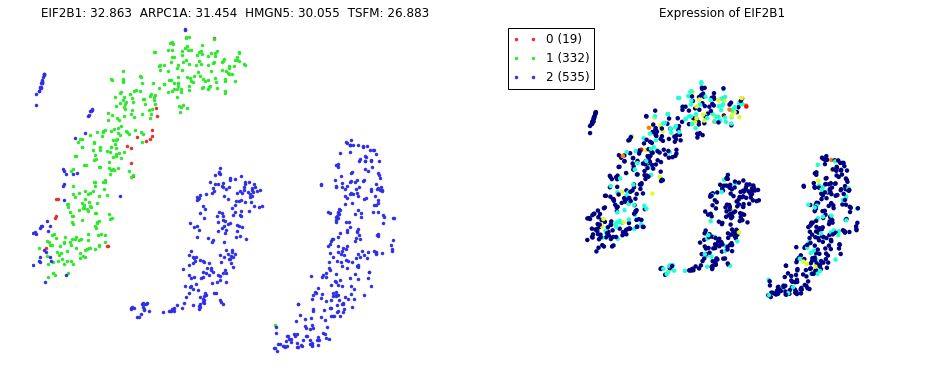

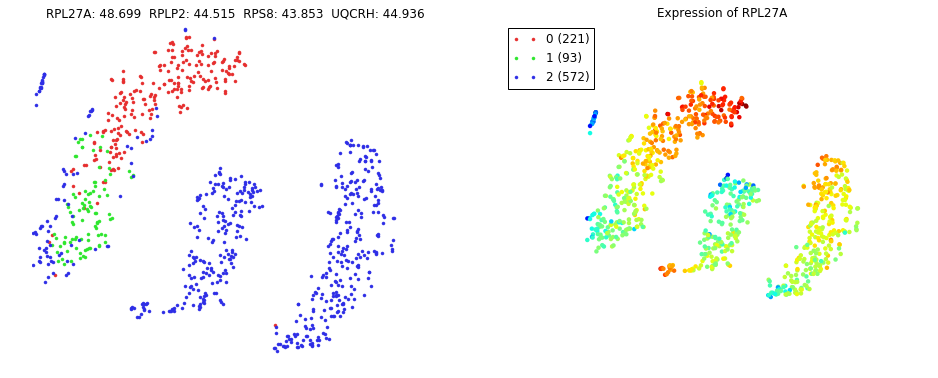

In [7]:
visualize_history(np.log(1+X),x1,x2,genes,history)